# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
#!mkdir /content/output
!mkdir content\output

In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

In [2]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

#base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
base_image_path = Path("content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
#style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
style_reference_image_path = Path("content/La_noche_estrellada1.jpg")
#result_prefix = Path("/content/output")
result_prefix = Path("content/output")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:
<br>Al combinar dos imágenes, estos parámetros indican el peso relativo que se le va a asignar en el modelo a la imagen de la que se toma el contenido (content_weight o alfa) y a la imagen usada para la reconstrucción del estilo (style weight o beta). <br>El parámetro total_variation_weight es el factor de suavizamiento de la Loss.

In [4]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [5]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta: se define una función que 
<br>**Primero:** load_img carga una imagen con un tamaño que se introduce como parámetro.
<br>**Segundo:** img_to_array transforma la imagen cargada en un NumPy array para facilitar el empleo de modelos de deep learning. Pasa a tener tamaño (img_nrows, img_ncols,3), donde el último elemento (3) representa los canales de la imagen. 
<br>**Tercero:** con expand_dims se genera un array de dimensión incrementada, se inserta 1 dimensión en la primera posición (axis=0) que representará la cantidad de imágenes a procesar. 
<br>**Cuarto:** vgg19.preprocess_input convierte la imagen de RGB to BGR, esto lo hace porque la VGG19 original fue entrenada con imágenes cargadas como BGR, se debe respetar ese orden en los canales. También normaliza las imágenes con respecto al dataset de ImageNet, resta la media de cada color (zero-center).

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta: se define una función que hace el proceso inverso a la definida en la celda anterior. Se recupera las características que fueron extraídas en la estandarización: vuelve la imagen a la dimensión original, le suma la media a cada canal (remueve el centrado en cero) y también vuelve la imagen a RGB.

In [7]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [9]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

In [10]:
base_image.shape

TensorShape([1, 400, 517, 3])

In [11]:
style_reference_image.shape

TensorShape([1, 400, 517, 3])

In [12]:
combination_image.shape

TensorShape([1, 400, 517, 3])

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [13]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [14]:
input_tensor.shape

TensorShape([3, 400, 517, 3])

In [15]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


In [16]:
outputs_dict

{'input_1': <tf.Tensor 'concat:0' shape=(3, 400, 517, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 517, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 400, 517, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 200, 258, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 200, 258, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 200, 258, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 100, 129, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 100, 129, 256) dtype=float32>,
 'block3_pool': <t

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
<br>Es el resultado de multiplicar una matriz dada por su matriz transpuesta. La matriz de Gram proporciona un grado de correlación entre los vectores de una matriz, entre los parámetros de diferentes filtros en una CNN. Se usa para calcular la style loss, que mide las diferencias entre el estilo de la imagen de referencia y la generada. No se usa para la imagen de contenido se quiere conservar las características espaciales.

- ¿Por qué se permutan las dimensiones de x?
<br>Para que la matriz de Gram quede con la dimensión correcta al hacer el producto de matrices.

In [17]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:
<br>**style_loss:** calcula el cuadrado de la diferencia entre la matriz Gram de estilo y la matriz Gram de la imagen. Hace que la imagen combinada y la imagen de estilo sean similares en las características de estilo.
<br>**content_loss:** mide la distancia de los features de contenido entre la imagen de contenido y la imagen generada. Es para que la imagen sintetizada y la imagen de contenido sean similares en las características de contenido.
<br>**total_variation_loss:** loss de regularización, ayuda a reducir el ruido de la imagen sintetizada y que sea coherente.  Reduce el ruido de alta frecuencia, producidon por cambios bruscos de los pixeles brillantes u oscuros.

In [18]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [19]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [20]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [21]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [22]:
loss = K.variable(0.0)
loss

<tf.Variable 'Variable_3:0' shape=() dtype=float32>

In [23]:
layer_features = outputs_dict['block5_conv2']
layer_features

<tf.Tensor 'block5_conv2/Relu:0' shape=(3, 25, 32, 512) dtype=float32>

In [24]:
base_image_features = layer_features[0, :, :, :]
base_image_features

<tf.Tensor 'strided_slice_26:0' shape=(25, 32, 512) dtype=float32>

In [25]:
combination_features = layer_features[2, :, :, :]
combination_features

<tf.Tensor 'strided_slice_27:0' shape=(25, 32, 512) dtype=float32>

In [26]:
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)
loss

<tf.Tensor 'add_8:0' shape=() dtype=float32>

In [27]:
feature_layers = ['block1_conv1']
feature_layers

['block1_conv1']

In [28]:
layer_features = outputs_dict['block1_conv1']
layer_features

<tf.Tensor 'block1_conv1/Relu:0' shape=(3, 400, 517, 64) dtype=float32>

In [29]:
style_reference_features = layer_features[1, :, :, :] 
style_reference_features

<tf.Tensor 'strided_slice_28:0' shape=(400, 517, 64) dtype=float32>

In [30]:
combination_features = layer_features[2, :, :, :]
combination_features

<tf.Tensor 'strided_slice_29:0' shape=(400, 517, 64) dtype=float32>

In [31]:
sl = style_loss(style_reference_features, combination_features)
sl

<tf.Tensor 'truediv_5:0' shape=() dtype=float32>

In [32]:
loss = loss + (style_weight / len(feature_layers)) * sl
loss

<tf.Tensor 'add_9:0' shape=() dtype=float32>

In [33]:
loss = loss + total_variation_weight * total_variation_loss(combination_image)
loss

<tf.Tensor 'add_11:0' shape=() dtype=float32>

In [34]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:
<br>Se calcula la Loss y los gradientes en funciones separadas acorde a los requisitos del módulo, pero ganando en eficiencia al computarlos conjutamente.Luego se itera n veces el proceso de optimización para lograr generar imágenes que se acerquen cada vez más al resultado deseado. <br>fmin_l_bfgs_b minimiza una función empleando el algoritmo de optimización L-BFGS-B. Este algoritmo es una aproximación de Broyden-Fletcher-Goldfarb-Shanno que emplea una cantidad limitada de memoria lo que lo hace eficiente en términos computacionales. En el paper se optimizó empleando descenso de gradiente. Se pueden utilizar otras alternativas como Adam.

In [35]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [36]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [37]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 533661000.0
Image saved as content\output\output_at_iteration_0.png
Iteration 0 completed in 280s
Start of iteration 1
Current loss value: 338121540.0
Image saved as content\output\output_at_iteration_1.png
Iteration 1 completed in 273s
Start of iteration 2
Current loss value: 288384770.0
Image saved as content\output\output_at_iteration_2.png
Iteration 2 completed in 276s
Start of iteration 3
Current loss value: 268878880.0
Image saved as content\output\output_at_iteration_3.png
Iteration 3 completed in 269s
Start of iteration 4
Current loss value: 257095890.0
Image saved as content\output\output_at_iteration_4.png
Iteration 4 completed in 248s
Start of iteration 5
Current loss value: 248833630.0
Image saved as content\output\output_at_iteration_5.png
Iteration 5 completed in 265s
Start of iteration 6
Current loss value: 243101600.0
Image saved as content\output\output_at_iteration_6.png
Iteration 6 completed in 234s
Start of iteration 7
Curren

Current loss value: 196648400.0
Image saved as content\output\output_at_iteration_58.png
Iteration 58 completed in 231s
Start of iteration 59
Current loss value: 196415460.0
Image saved as content\output\output_at_iteration_59.png
Iteration 59 completed in 230s
Start of iteration 60
Current loss value: 196196930.0
Image saved as content\output\output_at_iteration_60.png
Iteration 60 completed in 231s
Start of iteration 61
Current loss value: 195983840.0
Image saved as content\output\output_at_iteration_61.png
Iteration 61 completed in 230s
Start of iteration 62
Current loss value: 195773900.0
Image saved as content\output\output_at_iteration_62.png
Iteration 62 completed in 231s
Start of iteration 63
Current loss value: 195565650.0
Image saved as content\output\output_at_iteration_63.png
Iteration 63 completed in 230s
Start of iteration 64
Current loss value: 195362050.0
Image saved as content\output\output_at_iteration_64.png
Iteration 64 completed in 231s
Start of iteration 65
Curren

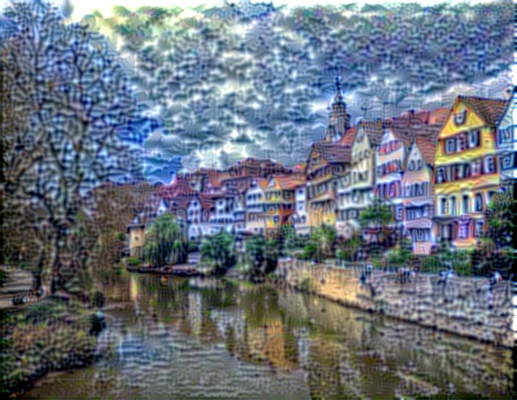

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Se realizaron tres pruebas, en cada una se modificó uno solo de los tres parámetros respecto de la notebook original, llevándose a pesos bastante distintos a los originales para que se aprecie mejor el impacto en resultados.
<br>En la primera prueba se aumentó el peso del total_variation_weight de 0.1 a 0.9. Se puede apreciar como resultado una imagen que pierde nitidez, los contornos del contenido se ven difuminados debido a que este parámetro refiere a la reducción del ruido en la imagen sintetizada.
<br>En la segunda prueba se bajó el peso del parámetro style_weight, de 10 a 0.1, dejando los restantes parámetros en mismos valores a la notebook original. Este nuevo valor dio como resultado una imagen que toma solo levemente los colores de la imagen de estilo. 
<br>Por último se verificó las diferencias en la imagen combinada producto de cambiar el parámtro content_weight, en este caso triplicándo el valor original. En este caso el contenido de la imagen toma mayor protagonismo, revelándose principalmente en una mayor claridad de las figuras y el color más similar al original del agua.

**Trial 1**
<br>Aumento el total_variation_weight
<br>total_variation_weight = 0.9
<br>style_weight = 10
<br>content_weight = 1
<br>archivo adjunto con nombre **trial1_output_at_iteration_99.png**

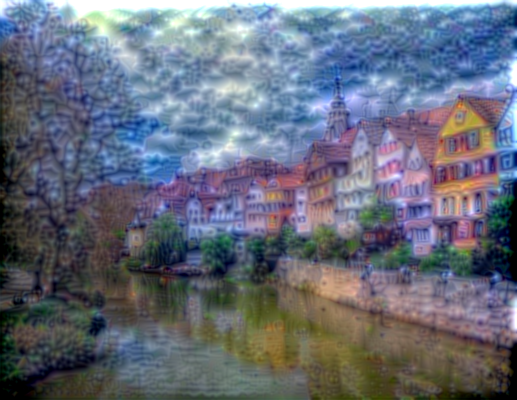

**Trial 2**
<br>Subo el style_weight 
<br>total_variation_weight = 0.1
<br>style_weight = 0.1
<br>content_weight = 1
<br>archivo adjunto con nombre **trial2_output_at_iteration_99.png**

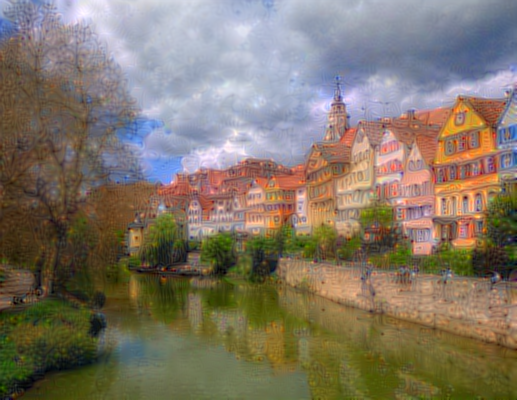

**Trial 3**
<br>Subo el content_weight
<br>total_variation_weight = 0.05
<br>style_weight = 10
<br>content_weight = 3
<br>archivo adjunto con nombre **trial3_output_at_iteration_99.png**

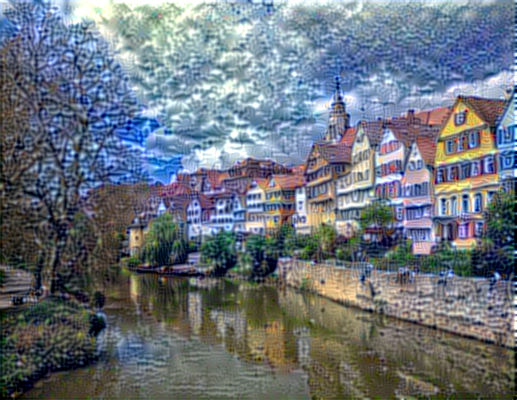

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:
<br>total_variation_weight = 0.1
<br>style_weight = 10
<br>content_weight = 1

**Imagen de contenido**
<br>archivo adjunto con nombre **dali_memory.png**

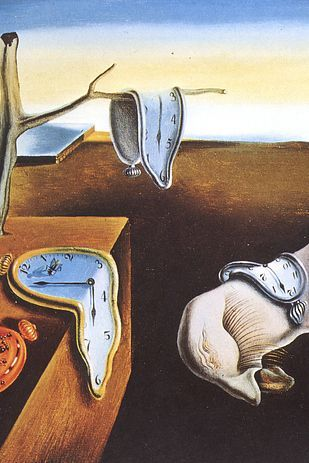

**Imagen de estilo**
<br>archivo adjunto con nombre **Carnivour_Creates.png**

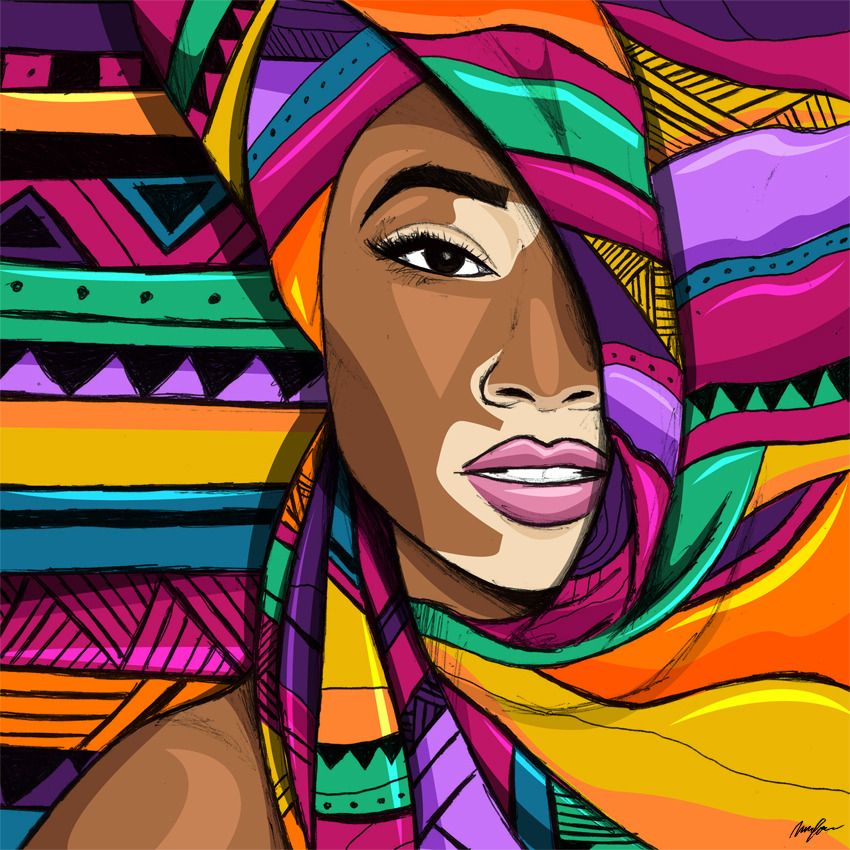

**Resultado final**
<br>archivo adjunto con nombre **trial4_output_at_iteration_99.png**

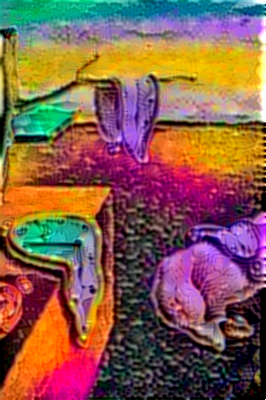